# TODO

1. [ ] Regression target variable big spike
2. [ ] Stardard VS normalized??
3. [x] Stardard before XBG -> no use? -> yes, no use

# Module 

In [63]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import datasets
from xgboost.sklearn import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from src.AssignmentTools.xgboost_tools import plot_feature_importances

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config 

In [10]:
data = datasets.fetch_california_housing()

In [14]:
X = pd.DataFrame(data.data)
y = pd.DataFrame(data.target)
X.columns = data.feature_names

# EDA & Data Process

## Label 

In [16]:
y.describe()

,0
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


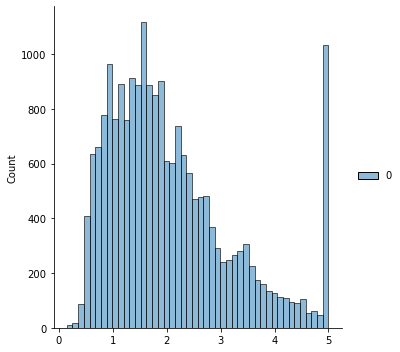

In [17]:
sns.displot(data=y, kind='hist')

## Features 

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [21]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [23]:
X.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [24]:
df = X
continuous_cols = X.columns

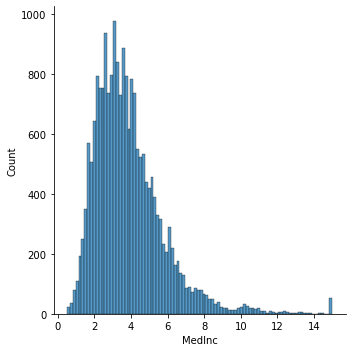

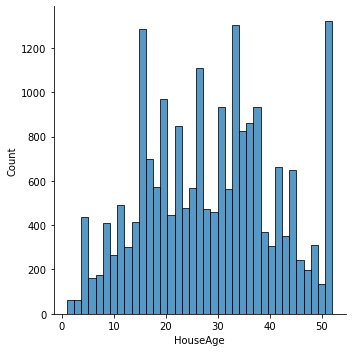

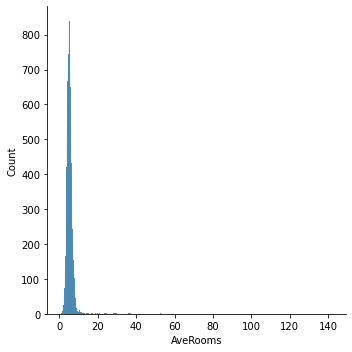

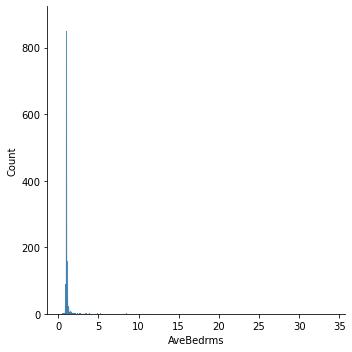

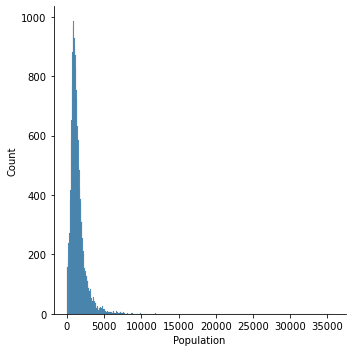

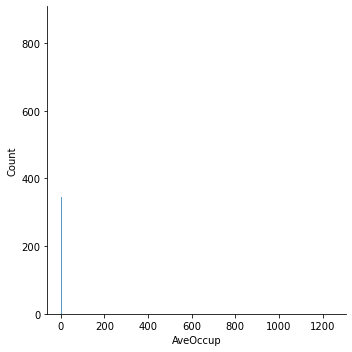

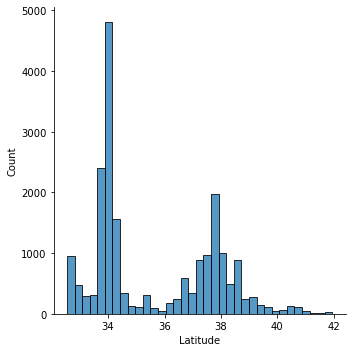

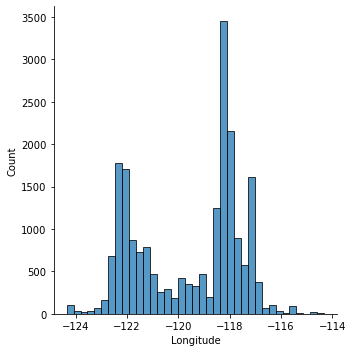

In [26]:
for col in continuous_cols:
    sns.displot(x=df[col])
#     plt.show()

## train test split 

In [30]:
train_X, test_X, train_y, test_y = train_test_split(X, y)

# Model Training 

## Grid Search 

In [58]:
xgb = XGBRegressor()

parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [
                  .03, 
                  #0.05, .07, 0.1
              ],
              'max_depth': [ 9 ],
              'min_child_weight': [1],
              'silent': [1],
              'subsample': [ #0.8, 0.9, 
                  0.95],
              'colsample_bytree': [ 0.8, #0.9, 0.95
                                  ],
              'n_estimators': [
                              #100, 
                              # 200, 300, 
                  500
                  #600, 700, 800, 900
                              ]
}
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)
xgb_grid.fit(train_X,
         train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

params = xgb_grid.best_params_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[21:23:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8314676321905692
{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.95}


## Model Evaluation With Cross Validation 

In [67]:
model = XGBRegressor(**params)
cv = RepeatedKFold(n_splits=10, n_repeats=3)
scores = cross_val_score(estimator=model, X=X, y=y, cv=cv)

[21:51:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/wor

[21:55:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/wor

In [72]:
print(f'Mean score: {np.mean(scores)}')

Mean score: 0.8561153468127359


## Model Training 

In [70]:
model = XGBRegressor(**params)
model.fit(train_X, train_y)


# pipe_lst = [model]

pipeline = make_pipeline(model)

# predict_test_y = pipeline.predict(test_X)
# predict_train_y = pipeline.predict(train_X)
# print(mean_squared_error(train_y, predict_train_y))
# print(mean_squared_error(test_y, predict_test_y))


[21:57:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




## Feature Importance 

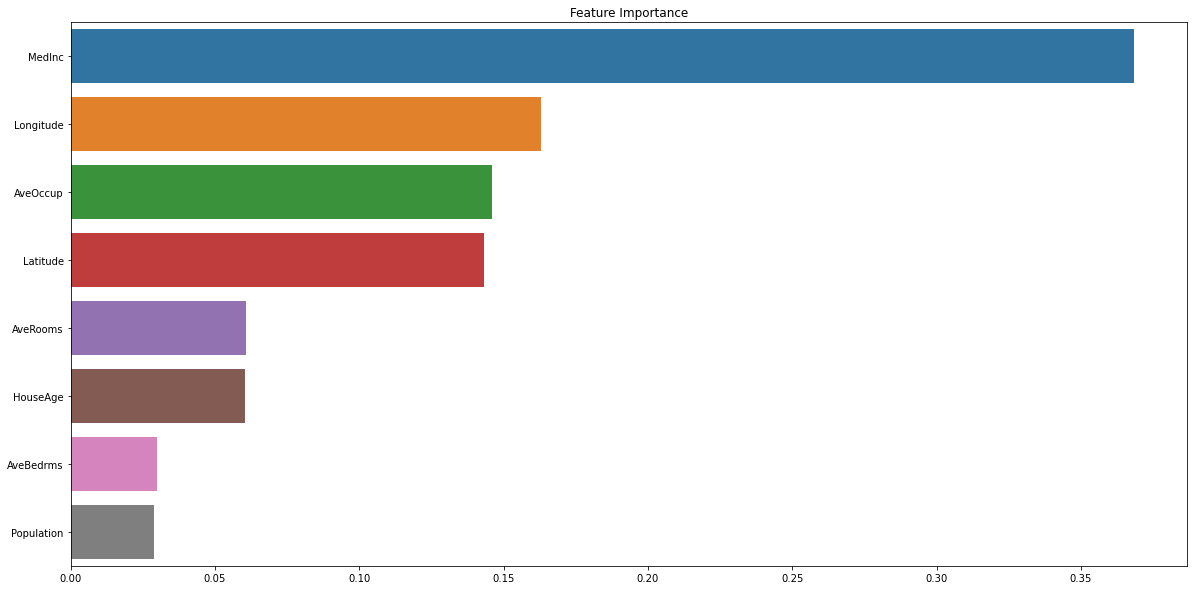

In [71]:
plot_feature_importances(model, train_X.columns, len(train_X.columns))